In [2]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [3]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu

In [4]:
job_params = {    
    'notch_filt' :     None,
    'planes' :         n.concatenate([n.arange(0,30,2), n.arange(1,31,2)]),
    'n_ch_tif' : 30,
    'convert_plane_ids_to_channel_ids' : False,
    
    'n_init_files' :   1,
    'init_file_pool' : None,
    'init_file_sample_method': 'random',
    
    'subtract_crosstalk' : True,
    'override_crosstalk' : 0.13,
    'crosstalk_n_planes' : 10, 
    
    'nonrigid' : True,
    'smooth_sigma' : 1.15,
    'maxregshift' : 0.15,
    'reg_filter_pcorr' : 1,
    'generate_sample_registered_bins' : False,

    'dtype' : n.float32,
    'tif_batch_size' : 1,
}



In [5]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'AH012',
    'date' :          '2024-05-17',
    'expnum' :         [1],}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params['fs'] = si_params['vol_rate']

savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=False, overwrite=True, verbosity = 100)

job.params['planes'] = n.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22,  1,  3,
         5,  7,  9, 11])
job.params['3d_reg'] = True
job.params['fuse_shift_override'] = 6
job.params['n_init_files'] = 4
job.params['init_n_frames'] = 400
job.params['cavity_size'] = 12
job.verbosity = 100

   Found and loaded params from /mnt/md0/runs/s3d-AH012_2024-05-17_1/params.npy


In [6]:
summary = job.load_summary()

In [7]:
ref_vol = summary['ref_img_3d']

In [8]:
sig_range_high = n.percentile(ref_vol, 99.99, axis=(1,2))
sig_range_low = n.percentile(ref_vol, 25, axis=(1,2))

In [51]:
init_mov = n.load(os.path.join(job.dirs['summary'],'init_mov.npy'))

init_mean = init_mov.mean(axis=1)
init_std = init_mov.std(axis=1)
nz,ny,nx = init_mean.shape

pcts = n.array([n.percentile(init_std[i].flatten(), 98)  for i in range(nz)])

top_pix = [init_std[i] > pcts[i] for i in range(nz)]

top_pix_movs = n.array([init_mov[i][:,top_pix[i]] for i in range(nz)])

ff = top_pix_movs
df = n.diff(ff, axis=1)
dff = df / ff.mean(axis=1,keepdims=True)
abs_d_dff = n.abs(n.diff(dff,axis=1))
noise_level = n.nanmedian(abs_d_dff, axis=1)
noise_level = noise_level / job.params['fs']

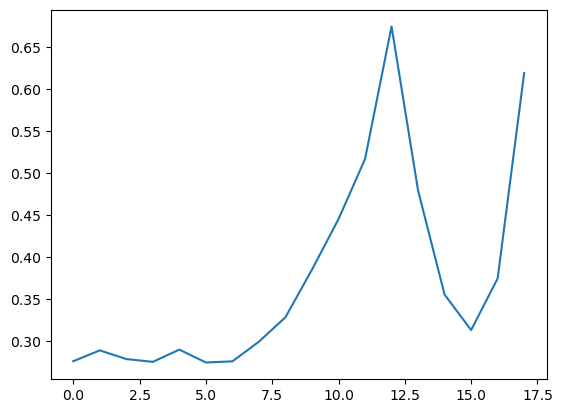

In [70]:
plt.plot(noise_level.mean(axis=1))

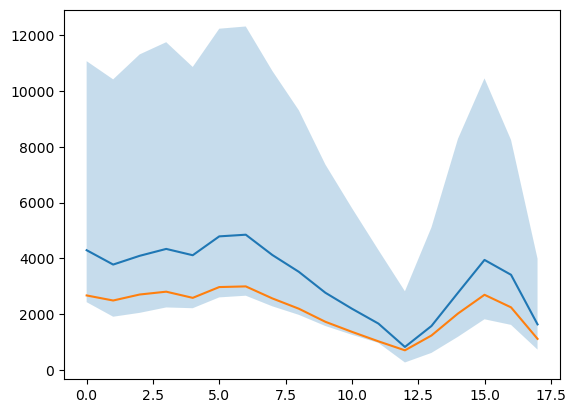

In [73]:
nz, ny, nx = ref_vol.shape

plt.plot(ref_vol.mean(axis=(1,2)))
plt.fill_between(n.arange(nz),sig_range_low, sig_range_high, alpha=0.25)
plt.plot(ref_vol.std(axis=(1,2)))

In [1]:
job

NameError: name 'job' is not defined